In [1]:
# --- Imports ---
%matplotlib inline

import geopandas as gpd
import math
import matplotlib
import numpy as np
import pandas as pd
import shapely
import sys,os
import multiprocessing
from geopandas import GeoDataFrame, GeoSeries
from shapely.geometry import Polygon, Point
from rtree import index



/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Load and clean constraint shapefiles

In [2]:
cities = GeoDataFrame.from_file('./geodata/ca_cities/Cities2015.shp')
water = GeoDataFrame.from_file('./geodata/baywater/bayarea_allwater.shp')

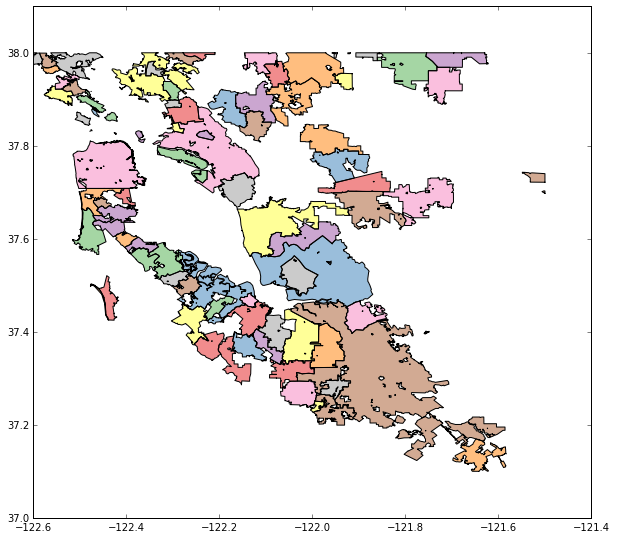

In [3]:

# This is the cropped area - full geojson is all cities in CA
bayarea = Polygon([(-122.6, 37.1), (-121.5,37.1), (-121.5,38), (-122.6,38)])
df = GeoDataFrame(geometry=GeoSeries([bayarea]),crs={'init': 'epsg:4269'})

# crop cities
ca_cities = cities.intersection(df.geometry.unary_union)

# convert water to same spatial projection
ca_water = water.to_crs(ca_cities.crs)

# Exclude water bodies using water shapefile
ca_cities_clean = ca_cities.difference(ca_water.geometry.unary_union)
ca_cities_clean.plot(figsize=(10,10))


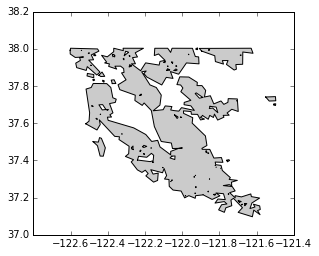

In [4]:

# Generate single geometry shape of target area
simple_ca = GeoDataFrame(geometry=GeoSeries(ca_cities_clean.buffer(0).geometry.unary_union),crs={'init': 'epsg:4269'})

# Buffer and reduce complexity of geometry - covers costal regions + improves performance
simple_ca = simple_ca.buffer(0.003).simplify(0.01, preserve_topology=True)
simple_ca.plot()


## Construct circle covering and transform to target area

CPU times: user 154 ms, sys: 32.4 ms, total: 186 ms
Wall time: 606 ms


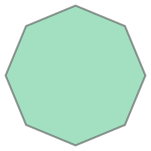

In [5]:

# Function transforming initial grid into hex grid layout
def create_point(data):
    i = data[0]
    j = data[1]
    r = data[2]
    xoffset = 0
    yoffset = 0
    p = Point(i*r*math.sqrt(3) + (r*math.sqrt(3)/2 if j%2 else 0) + xoffset,
              j*r*3/4*2+yoffset)
    return shapely.affinity.scale(p.buffer(7).simplify(0.8, preserve_topology=False), xfact=r/7, yfact=r/7)


def create_circle_covering(r, width, height):
    # Accumulate initial circle grid
    circles = []
    for i in range(0, width):
        for j in range(0, height):
            circles.append([i,j,r])

    # Parallel conversion
    pool = multiprocessing.Pool(multiprocessing.cpu_count()-1)
    return pool.map(create_point, circles)


# Render the initial circle, demonstrating size and shape
%time circles = create_circle_covering(70, 50, 50)
circles[0]


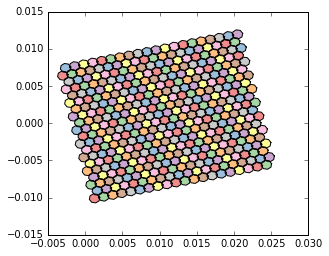

In [6]:
circles = create_circle_covering(70, 20, 20)

def transform_and_normalize_circle_covering(circles):
    # EPSG:2768 ca meters
    search_circles = GeoDataFrame(geometry=GeoSeries(circles))
    df = GeoDataFrame(geometry=GeoSeries(circles))
    df.crs = {'init': 'epsg:2768'}

    # Transfrom from meter baed EPSG:2768 coordinate system to lat/long degrees based EPSG:4269
    df = df.to_crs(ca_cities_clean.crs)

    # Translation normalization from offset due to change in coordinate systems
    df = df.translate(xoff=141.22, yoff=-30.02, zoff=0.0)
    return df

df = transform_and_normalize_circle_covering(circles)
#df.plot()

def translate_circle_covering(covering, lng, lat):
    # Translate circle covering to target location
    #%time df = df.translate(xoff=-122.2, yoff=37.4, zoff=0.0)
    df = covering.translate(xoff=lng, yoff=lat, zoff=0.0)
    return df

df = translate_circle_covering(df, 0, 0)
df.plot()

## Load existing spawn data + store in rtree for existing spawn selection

In [7]:
mons = pd.read_csv('./data/pokemon.csv', skiprows=1, usecols=[3,4,5,6], names=["num", "lat", "lng", "time"], low_memory=False)
mons.last_valid_index()

7314094

In [8]:

# Build rtree indexed dataset of existing mon spawns
idx = index.Index()

filtered_mon = mons.query('36<lat<38.1 and -123<lng<-120')
lats = filtered_mon['lat'].as_matrix()
lons = filtered_mon['lng'].as_matrix()
position_stack = np.dstack((lons,lats))

cells = []

# Populate R-tree index with bounds of grid cells
for pos, cell in enumerate(position_stack[0]):
    idx.insert(pos, (cell[0], cell[1],cell[0]+0.001, cell[1]+0.001))

filtered_mon.shape


(227413, 4)

## Filter circle query points to intersections with geometric set

In [ ]:

# Filter all circles to intersection with the target geometry
simple_ca_union = simple_ca.buffer(0).geometry.unary_union

def filter_circles_not_inside(data):
    if simple_ca_union.intersects(data):
        return data
    else:
        return False

final_circles = []
pool = multiprocessing.Pool(multiprocessing.cpu_count()-1)
%time final_circles = filter(lambda x: x != False, pool.map(filter_circles_not_inside, df.geometry))

search_circles = GeoDataFrame(geometry=GeoSeries(final_circles))
search_circles.plot(figsize=(10,10))

In [ ]:
search_circles.plot(ax=ca_cities_clean.plot(figsize=(10,10)), figsize=(10,10))

## Coverage based solely on existing spawn points

In [ ]:

# Filter all circles to intersection with the target geometry

def filter_circles_not_inside(data):
    if len(list(idx.intersection(data.bounds))):
        return data
    else:
        return False

final_circles = []
pool = multiprocessing.Pool(multiprocessing.cpu_count()-1)
%time final_circles = filter(lambda x: x != False, pool.map(filter_circles_not_inside, df.geometry))

search_circles = GeoDataFrame(geometry=GeoSeries(final_circles))
search_circles.plot(ax=ca_cities_clean.plot(figsize=(10,10)), figsize=(10,10))

## Chunked rect covering for worker allocation

CPU times: user 40.8 ms, sys: 16.8 ms, total: 57.6 ms
Wall time: 49.9 ms


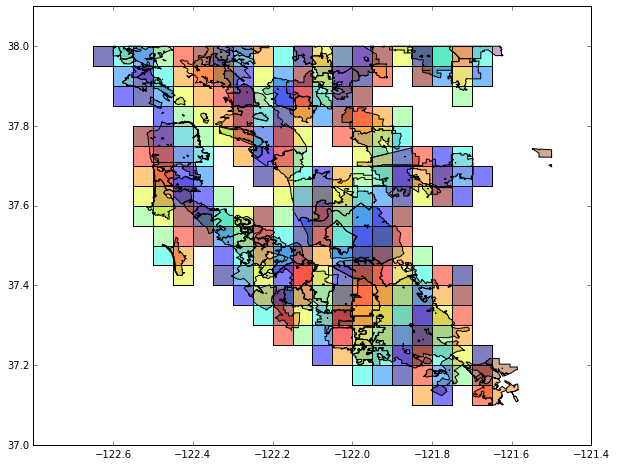

In [10]:
rects = []
rectStartLng = -122.65
rectStartLat = 37.0
width = 0.05
for i in range(0,20):
    rectLng = rectStartLng + width * i
    for j in range(0,20):
        rectLat = rectStartLat + width * j
        rects.append(Polygon([(rectLng, rectLat), (rectLng+width,rectLat), (rectLng+width,rectLat+width), (rectLng,rectLat+width)]))

search_rects = GeoDataFrame(geometry=GeoSeries(rects))

simple_ca_union = simple_ca.buffer(0).geometry.unary_union

def filter_rects_not_inside(data):
    if simple_ca_union.intersects(data):
        return data
    else:
        return False

final_rects = []
pool = multiprocessing.Pool(multiprocessing.cpu_count()-1)
%time final_rects = filter(lambda x: x != False, pool.map(filter_rects_not_inside, search_rects.geometry))
        
        
search_rects = GeoDataFrame(geometry=GeoSeries(final_rects))
search_rects.plot(ax=ca_cities_clean.plot(figsize=(10,10)), figsize=(10,10))


CPU times: user 771 ms, sys: 327 ms, total: 1.1 s
Wall time: 2.22 s


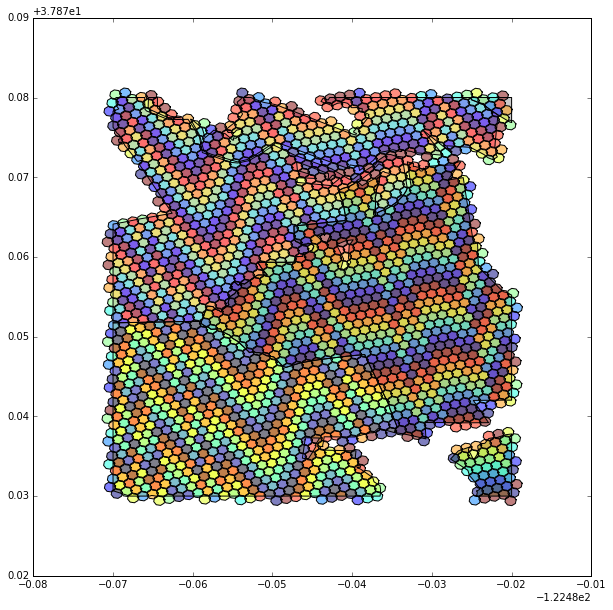

In [12]:
circle_covering = create_circle_covering(70, 50, 65)
norm_covering = transform_and_normalize_circle_covering(circle_covering)
#df = translate_circle_covering(df, -122.6, 37)

for r in search_rects.geometry[10:11]:
    bounded_rect = ca_cities_clean.intersection(r)
    bounded_rect_union = bounded_rect.geometry.unary_union
    b = bounded_rect_union.bounds
    trans_covering = translate_circle_covering(norm_covering, b[0], b[1])
    
    def filter_circles_not_inside(data):
        if bounded_rect_union.intersects(data):
            return data
        else:
            return False
        
    final_circles = []
    pool = multiprocessing.Pool(multiprocessing.cpu_count()-1)
    %time final_circles = filter(lambda x: x != False, pool.map(filter_circles_not_inside, trans_covering.geometry))

    search_circles = GeoDataFrame(geometry=GeoSeries(final_circles))
    search_circles.plot(ax=bounded_rect.plot(figsize=(10,10)), figsize=(10,10))
    #trans_covering.plot(ax=bounded_rect.plot(figsize=(10,10)), figsize=(10,10))

    
    

CPU times: user 281 ms, sys: 59.3 ms, total: 340 ms
Wall time: 1.74 s


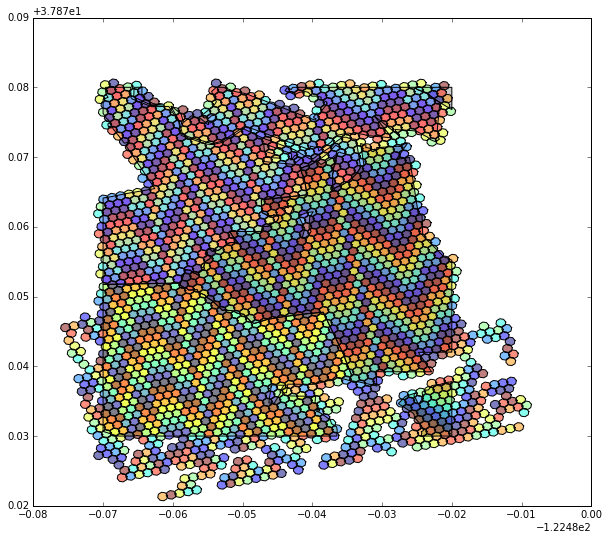

In [11]:
circle_covering = create_circle_covering(70, 50, 65)
norm_covering = transform_and_normalize_circle_covering(circle_covering)
#df = translate_circle_covering(df, -122.6, 37)

for r in search_rects.geometry[10:11]:
    bounded_rect = ca_cities_clean.intersection(r)
    bounded_rect_union = bounded_rect.geometry.unary_union
    b = bounded_rect_union.bounds
    trans_covering = translate_circle_covering(norm_covering, b[0], b[1])
    
    def filter_circles_not_inside(data):
        if len(list(idx.intersection(data.bounds))) or bounded_rect_union.intersects(data):
            return data
        else:
            return False
        
    final_circles = []
    pool = multiprocessing.Pool(multiprocessing.cpu_count()-1)
    %time final_circles = filter(lambda x: x != False, pool.map(filter_circles_not_inside, trans_covering.geometry))

    search_circles = GeoDataFrame(geometry=GeoSeries(final_circles))
    search_circles.plot(ax=bounded_rect.plot(figsize=(10,10)), figsize=(10,10))
    #trans_covering.plot(ax=bounded_rect.plot(figsize=(10,10)), figsize=(10,10))

    
    